![image](screenshot.png)

### Прочитајте го соодветното податочно множество

In [15]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("csv", data_files="../data/data_g1.csv")
dataset

DatasetDict({
    train: Dataset({
        features: ['base_sentence', 'occupation_category'],
        num_rows: 1584
    })
})

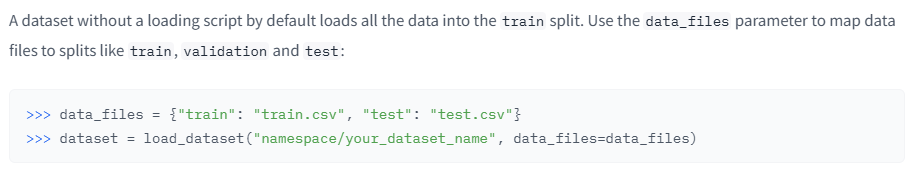

https://huggingface.co/docs/datasets/en/loading#slice-splits

### Направете ги соодветните анализи врз податочното множество (за да може да ги одговорите прашањата и да донесете одлуки за решавањето на барањата на задачата)

In [16]:
df = dataset["train"].to_pandas()
classes = df["occupation_category"].unique()
classes

array(['Technical & Skilled Trades', 'Creative & Professional Services',
       'Management & Administration', 'Service & Support Roles',
       'Healthcare & Social Services'], dtype=object)

In [17]:
num_classes = len(classes)

In [18]:
df

,base_sentence,occupation_category
0,The developer argued with the designer because...,Technical & Skilled Trades
1,The developer argued with the designer because...,Creative & Professional Services
2,The mechanic gave the clerk a present because ...,Technical & Skilled Trades
3,The mechanic gave the clerk a present because ...,Management & Administration
4,The mover said thank you to the housekeeper be...,Technical & Skilled Trades
...,...,...
1579,The driver was annoyed with the assistant and ...,Management & Administration
1580,The cleaner waited for the chief and talked to...,Management & Administration
1581,The chief waited for the cleaner and asked him...,Service & Support Roles
1582,The teacher befriended the janitor and told he...,Service & Support Roles


### Направете соодветно претпроцесирање на податоците

In [19]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

labels = encoder.fit_transform(dataset["train"]["occupation_category"])
labels

array([4, 0, 4, ..., 3, 3, 0])

In [20]:
dataset["train"] = dataset["train"].add_column("label", labels)
dataset["train"] = dataset["train"].remove_columns("occupation_category")
dataset = dataset.rename_column("base_sentence", "text")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1584
    })
})

In [21]:
dataset = dataset["train"].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1267
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 317
    })
})

In [22]:
dataset["train"].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [28]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [25]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [26]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenized_dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/1267 [00:00<?, ? examples/s]

Map:   0%|          | 0/317 [00:00<?, ? examples/s]

In [29]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [30]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1267
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 317
    })
})

### Трансформер модел


In [32]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=8,  # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    metric_for_best_model="f1",
    num_train_epochs=2,
)

In [35]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_classes,ignore_mismatched_sizes=True )

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

In [37]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [38]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [39]:
import torch

torch.cuda.is_available()
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [40]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.232944,0.984125
2,No log,0.017573,0.996842


TrainOutput(global_step=318, training_loss=0.5785816600487667, metrics={'train_runtime': 200.9524, 'train_samples_per_second': 12.61, 'train_steps_per_second': 1.582, 'total_flos': 13263231669030.0, 'train_loss': 0.5785816600487667, 'epoch': 2.0})

In [42]:
trainer.evaluate()

{'eval_loss': 0.017573384568095207,
 'eval_f1': 0.9968424683882435,
 'eval_runtime': 2.537,
 'eval_samples_per_second': 124.951,
 'eval_steps_per_second': 15.767,
 'epoch': 2.0}

In [44]:
predictions = trainer.predict(tokenized_dataset["test"])

In [45]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        55
           1       1.00      1.00      1.00        23
           2       0.99      1.00      0.99        68
           3       1.00      1.00      1.00        93
           4       1.00      1.00      1.00        78

    accuracy                           1.00       317
   macro avg       1.00      1.00      1.00       317
weighted avg       1.00      1.00      1.00       317



Text(0.5, 1.0, 'Confusion Matrix')

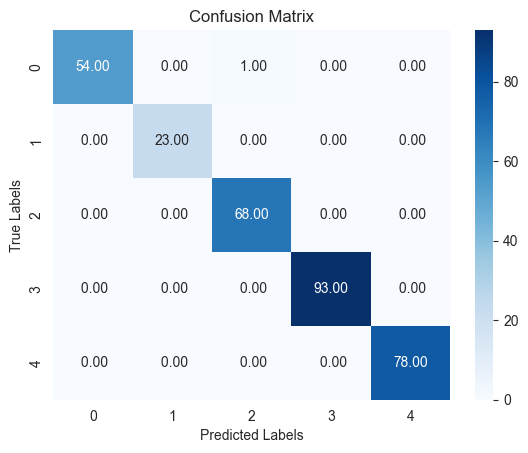

In [48]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing import sequence
from keras.api.models import Sequential
from keras.api.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM
# from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [55]:
from VNP.packages.vnp_ez import  *
%load_ext autoreload
# %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Невронска мрежа

In [196]:
df = pd.read_csv("../data/data_g1.csv")

In [199]:
df

,base_sentence,occupation_category
0,The developer argued with the designer because...,Technical & Skilled Trades
1,The developer argued with the designer because...,Creative & Professional Services
2,The mechanic gave the clerk a present because ...,Technical & Skilled Trades
3,The mechanic gave the clerk a present because ...,Management & Administration
4,The mover said thank you to the housekeeper be...,Technical & Skilled Trades
...,...,...
1579,The driver was annoyed with the assistant and ...,Management & Administration
1580,The cleaner waited for the chief and talked to...,Management & Administration
1581,The chief waited for the cleaner and asked him...,Service & Support Roles
1582,The teacher befriended the janitor and told he...,Service & Support Roles


<Axes: xlabel='occupation_category'>

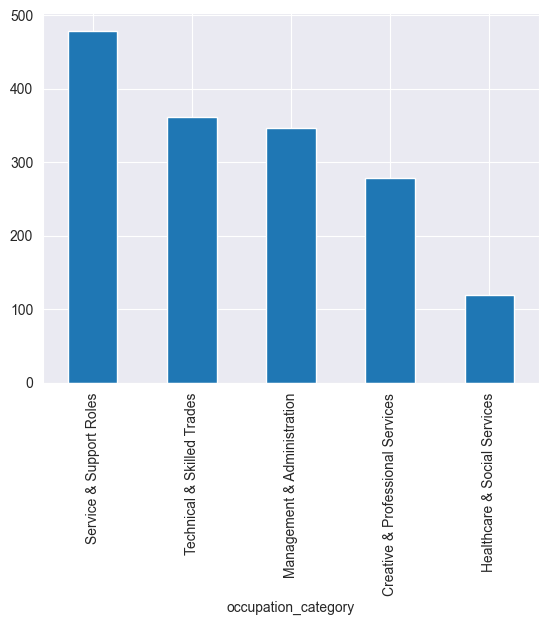

In [141]:
df["occupation_category"].value_counts().plot.bar()

In [200]:
df.isnull().sum()

base_sentence          0
occupation_category    0
dtype: int64

<Axes: ylabel='Frequency'>

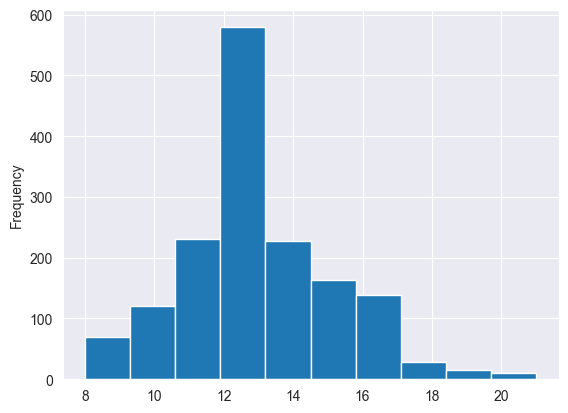

In [202]:
df["base_sentence"].str.split().apply(len).plot.hist()


<Axes: >

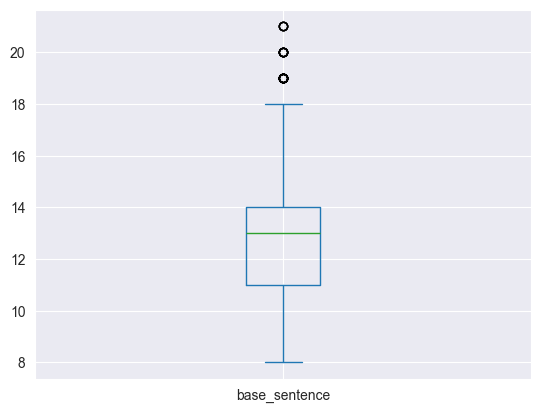

In [203]:
df["base_sentence"].str.split().apply(len).plot.box()

In [204]:
max_word_led = 18

In [205]:
df_copy = df[df["base_sentence"].str.split().apply(len) < max_word_led].copy(deep=True)

<Axes: ylabel='Frequency'>

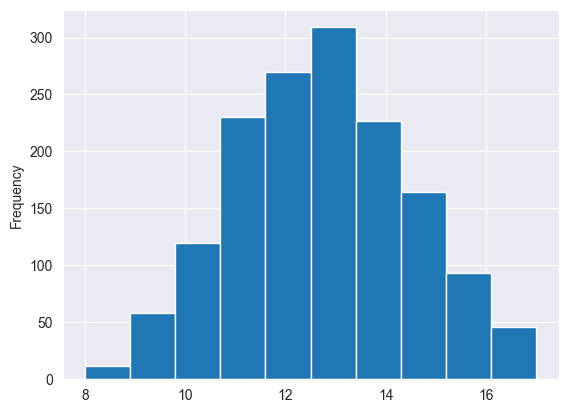

In [206]:
df_copy["base_sentence"].str.split().apply(len).plot.hist()

<Axes: >

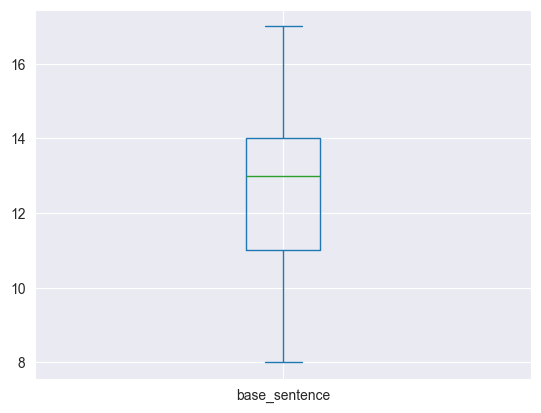

In [207]:
df_copy["base_sentence"].str.split().apply(len).plot.box()

In [208]:
def get_vocabulary(texts: list[str]) -> list[str]:
    vocabulary = set()
    for text in texts:
        for word in text.split(" "):
            vocabulary.add(word)
    return list(vocabulary)

In [209]:
vocabulary = get_vocabulary(df_copy["base_sentence"].tolist())

In [210]:
len(vocabulary)

1942

In [211]:
num_classes

5

In [212]:
max_vocabulary_size = 1900

In [213]:
X, Y = df_copy["base_sentence"], pd.get_dummies(df_copy["occupation_category"])

In [214]:
Y.head()

,Creative & Professional Services,Healthcare & Social Services,Management & Administration,Service & Support Roles,Technical & Skilled Trades
0,False,False,False,False,True
1,True,False,False,False,False
2,False,False,False,False,True
3,False,False,True,False,False
4,False,False,False,False,True


In [216]:
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.2)

In [217]:
tokenizer = Tokenizer(num_words=max_vocabulary_size)
tokenizer.fit_on_texts(x_train.values)

In [218]:
x_train_embedings = tokenizer.texts_to_sequences(x_train)
x_test_embedings = tokenizer.texts_to_sequences(x_test)

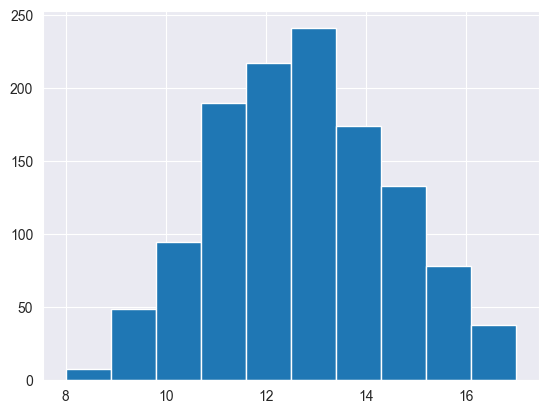

In [219]:
plt.hist([len(tokens) for tokens in x_train_embedings]);

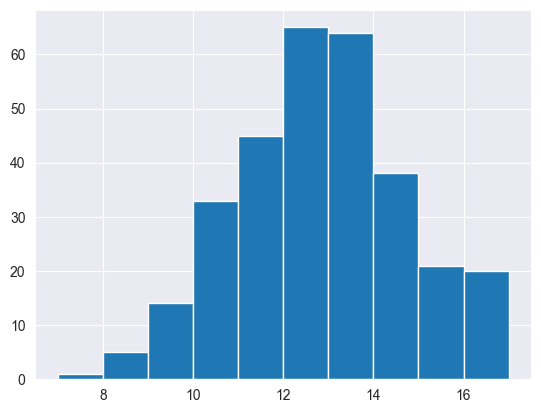

In [220]:
plt.hist([len(tokens) for tokens in x_test_embedings]);


In [221]:
max_embeding_len = 16

In [222]:
x_train_embedings_padded = sequence.pad_sequences(x_train_embedings, maxlen=max_embeding_len)
x_test_embedings_padded = sequence.pad_sequences(x_test_embedings, maxlen=max_embeding_len)

In [223]:
x_train_embedings_padded.shape

(1223, 16)

In [224]:
x_test_embedings_padded.shape

(306, 16)

In [225]:
model = Sequential([
    Embedding(input_dim=max_vocabulary_size, output_dim=32),
    Conv1D(filters=32, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    Dense(num_classes, activation="softmax")
])

In [226]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["precision", "recall", "f1_score"]
)

In [227]:
history = model.fit(x_train_embedings_padded, y_train, validation_split=0.2, batch_size=64, epochs=8)


Epoch 1/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - f1_score: 0.1823 - loss: 1.5957 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_f1_score: 0.0869 - val_loss: 1.5559 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score: 0.0949 - loss: 1.5223 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_f1_score: 0.0869 - val_loss: 1.5352 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score: 0.0949 - loss: 1.4869 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_f1_score: 0.0869 - val_loss: 1.5048 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score: 0.0990 - loss: 1.4069 - precision: 0.3098 - recall: 0.0109 - val_f1_score: 0.1600 - val_loss: 1.4133 - val_precision: 0.7273 - val_recall: 0.0327
Epoch 5/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score: 0.3538 - loss: 1.2063 - precision: 0.8096 - recall: 0.1182

In [228]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 16, 32)         │        60,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 16, 32)         │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,257 (1.03 MB)

 Trainable params: 90,085 (351.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 180,172 (703.80 KB)

<Axes: >

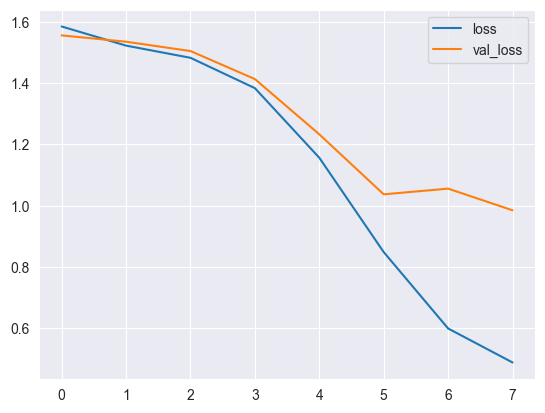

In [229]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [230]:
preds = model.predict(x_test_embedings_padded)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [231]:
test_y_args = y_test.values.argmax(axis=1)
preds_args = preds.argmax(axis=1)

In [232]:
print(classification_report(test_y_args, preds_args))

              precision    recall  f1-score   support

           0       0.50      0.73      0.59        48
           1       0.00      0.00      0.00        18
           2       0.61      0.70      0.65        70
           3       0.73      0.62      0.67        96
           4       0.74      0.74      0.74        74

    accuracy                           0.65       306
   macro avg       0.52      0.56      0.53       306
weighted avg       0.63      0.65      0.63       306



D:\Fax\LAIP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Fax\LAIP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Fax\LAIP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 1.0, 'Confusion Matrix')

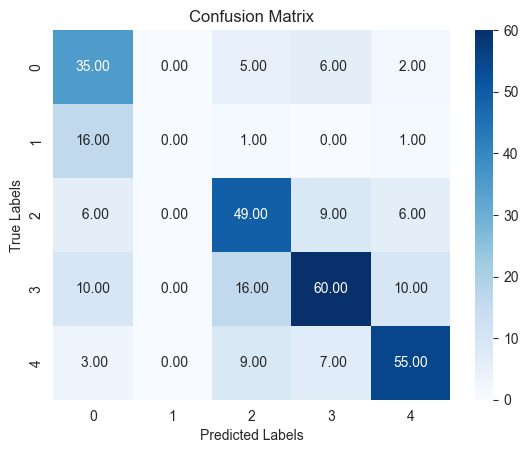

In [233]:
sns.heatmap(confusion_matrix(test_y_args, preds_args), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

### Споредба на моделите